In [1029]:
#Imports
import time
start_time = time.time()

import pandas as pd
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import mlxtend as ml



In [1030]:
#Load data

offline_sales = pd.read_json("offline_sales.json", lines = True)
online_orders = pd.read_json("online_orders.json", lines = True)
online_views = pd.read_json("online_pageviews.json", lines = True)

## Optmizing the size of the dataframes

In [1031]:
offline_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29372 entries, 0 to 29371
Data columns (total 8 columns):
customer_id       25844 non-null float64
date              29372 non-null datetime64[ns]
off_product_id    29372 non-null int64
price             29372 non-null float64
quantity          29372 non-null int64
sale_id           29372 non-null int64
state             29372 non-null object
store_id          29372 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1.8+ MB


In [1032]:
online_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12237 entries, 0 to 12236
Data columns (total 8 columns):
customer_id      7757 non-null float64
date             12237 non-null datetime64[ns]
deviceType       12237 non-null object
on_product_id    12237 non-null int64
order_id         12237 non-null int64
price            12237 non-null int64
quantity         12237 non-null int64
visitor_id       12237 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 764.9+ KB


In [1033]:
offline_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29372 entries, 0 to 29371
Data columns (total 8 columns):
customer_id       25844 non-null float64
date              29372 non-null datetime64[ns]
off_product_id    29372 non-null int64
price             29372 non-null float64
quantity          29372 non-null int64
sale_id           29372 non-null int64
state             29372 non-null object
store_id          29372 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1.8+ MB


In [1034]:
#Calculates memory usage before changing datatype
memory_usage0 = offline_sales.memory_usage().sum() + online_orders.memory_usage().sum() + online_views.memory_usage().sum() 

#Change datatype
offline_sales["state"] = offline_sales["state"].astype('category')
offline_sales["price"] = pd.to_numeric(offline_sales["price"], downcast = 'float')
online_orders["deviceType"] = online_orders["deviceType"].astype('category')

#Calculates memory usage optimization
memory_usage1 = offline_sales.memory_usage().sum() + online_orders.memory_usage().sum() + online_views.memory_usage().sum() 
memory_save = (memory_usage0 - memory_usage1)/memory_usage0*100
print("The dataframe has been optmized in",memory_save,"%")

The dataframe has been optmized in 0.2082834877820952 %


## Questão 1 

In [1035]:
#Calculates total price of a purchase
offline_sales["totalPrice"] = offline_sales["price"]*offline_sales["quantity"].astype(int)
online_orders["totalPrice"] = online_orders["price"]*online_orders["quantity"].astype(int)

In [1036]:
#Calculates total revenue
revenue = offline_sales["totalPrice"].sum() + online_orders["totalPrice"].sum()
print("The revenue of the period is R$",revenue)

The revenue of the period is R$ 19552328.0


## Questão 2

In [1037]:
#Analyzes most sold product online
print("The most sold product online is",online_orders.groupby(online_orders['on_product_id'])['quantity'].sum().idxmax())

The most sold product online is 626664333563363


## Questão 3.1

In [1038]:
#Merge the dataframes and drop NaN
online_orders_state = online_orders.merge(offline_sales[['customer_id','state']], on = "customer_id")
online_orders_state.dropna(subset = ['customer_id'], inplace = True)

#Drop columns
online_orders_state.drop(['deviceType','on_product_id','order_id','visitor_id'], axis = 1, inplace = True)
offline_sales_state = offline_sales.drop(['off_product_id','sale_id'], axis = 1)

#Concatenate dataframes
sales = pd.concat([online_orders_state, offline_sales_state])

/dev/data/home/eller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [1039]:
#Add days of the week to the df
sales['dayOfTheWeek'] = sales['date'].dt.dayofweek

In [1040]:
#Analyzes revenue on RJ per day of the week
sales_rj_per_day = sales[sales['state'] == 'RJ'].groupby(sales['dayOfTheWeek'])['totalPrice'].sum()
sales_rj_weekdays = statistics.mean(sales_rj_per_day[0:5])
sales_rj_weekends = statistics.mean(sales_rj_per_day[5:7])


Text(0, 0.5, 'Revenue')

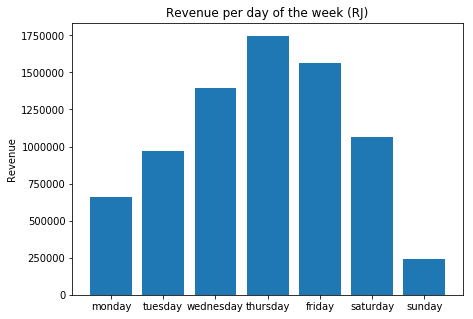

In [1041]:
#Plot graphic days of the week
days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
plt.rcParams['figure.figsize'] = (7,5)
plt.bar(days, sales_rj_per_day)
plt.title('Revenue per day of the week (RJ)')
plt.ylabel('Revenue')




Text(0, 0.5, 'Revenue')

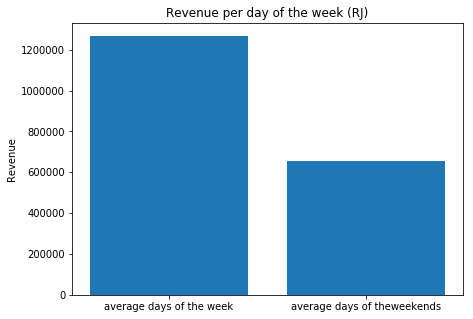

In [1042]:
#Plot graphic weekend x weekdays
plt.bar(['average days of the week', 'average days of theweekends'], [sales_rj_weekdays, sales_rj_weekends])
plt.title('Revenue per day of the week (RJ)')
plt.ylabel('Revenue')


## Questão 3.2

In [1043]:
#Calculate the percentage of the money spent on the weekends in relation to all the money spent (all days) for each state
sales_state_per_day = sales.groupby(['dayOfTheWeek', 'state'], as_index = False)['totalPrice'].sum()
state_list = list(sales_state_per_day['state'].value_counts().index)

#List lists
state_average = []
state_percentage = []
average_spent_on_weekends = []

#Iterates for each state
for state in state_list:
    average = (sales_state_per_day[sales_state_per_day['state'] == state]['totalPrice'][5:7]).sum()/2
    average_spent_on_weekends.append(average)
    percentage = average/sales_state_per_day[sales_state_per_day['state'] == state]['totalPrice'].sum()
    state_percentage.append(percentage)

#Creates dataframe with data
percentage_on_weekends_per_state = pd.DataFrame(list(zip(state_list, state_percentage)))
df_average_spent_on_weekends = pd.DataFrame(list(zip(state_list, average_spent_on_weekends))).rename(columns = {0:'state', 1:'average_weekends'})


Text(0.5, 0, 'State')

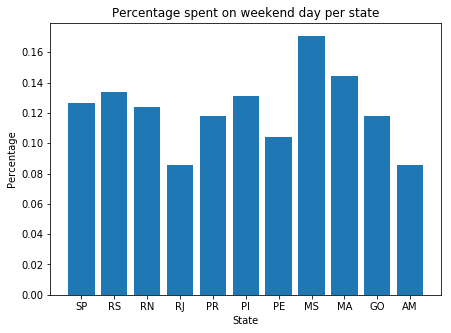

In [1044]:
#Plot graph
plt.bar(state_list,percentage_on_weekends_per_state[1])
plt.title('Percentage spent on weekend day per state')
plt.ylabel('Percentage')
plt.xlabel('State')

## Questão 3.3 

In [1045]:
#Import external data
dados_estados_brasileiros = pd.read_excel("dados_estados_brasileiros (1).xlsx")

dados_estados_brasileiros = df_average_spent_on_weekends.merge(dados_estados_brasileiros, on='state')


In [1046]:
#Evaluates the percentage of GPD per capita spent on weekends for each state
gpd_spent_on_weekends = dados_estados_brasileiros['average_weekends']/(dados_estados_brasileiros['habitants']*dados_estados_brasileiros['gpd_per_capita'])


Text(0.5, 0, 'State')

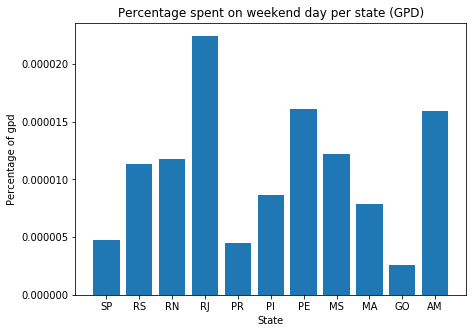

In [1047]:
plt.bar(state_list,gpd_spent_on_weekends)
plt.title('Percentage spent on weekend day per state (GPD)')
plt.ylabel('Percentage of gpd')
plt.xlabel('State')

## Questão 3.4

Text(0.5, 0, 'State')

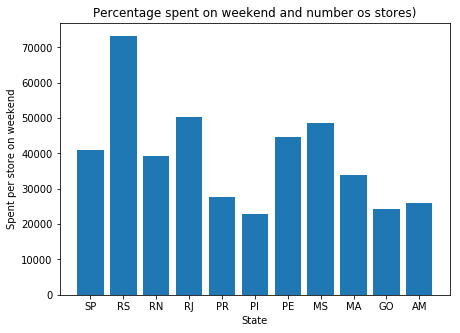

In [1048]:
#Get a list with number of stores per state
number_of_stores = []
for state in state_list:
    n = len(set(offline_sales[offline_sales['state'] == state]['store_id']))
    number_of_stores.append(n)
    
#Calculates the average spent per store on weekends for each state
average_on_weekends = pd.DataFrame(list(zip(state_list, number_of_stores, average_spent_on_weekends)))
average_on_weekends.rename(columns = {0:'state', 1:'number_of_stores', 2:'average_spent_on_weekends'}, inplace = True)
average_on_weekends['average_on_weekend_per_store'] = average_on_weekends['average_spent_on_weekends']/average_on_weekends['number_of_stores']

#Plot graphic
plt.bar(average_on_weekends['state'],average_on_weekends['average_on_weekend_per_store'])
plt.title('Percentage spent on weekend and number os stores)')
plt.ylabel('Spent per store on weekend')
plt.xlabel('State')


## Questão 3.5 

In [1049]:
#Add column week to df
sales['week'] = sales['date'].dt.week

#Creates new df for RJ's sales
sales_rj = sales[sales['state'] == 'RJ']

In [1050]:
#Separate dfs in week days and weekend days
sales_rj_weekly = sales_rj.groupby(['week','dayOfTheWeek'], as_index = False)['totalPrice'].sum()
sales_rj_weekly_weekend = sales_rj_weekly[sales_rj_weekly['dayOfTheWeek'] >= 5]
sales_rj_weekly_weekdays = sales_rj_weekly[sales_rj_weekly['dayOfTheWeek'] < 5]


#Calculates the average percentage of week days and weekend days for each week
week_list = list(sales_rj_weekly_weekend['week'].value_counts().index)
semana = []
average_per_week_weekends = []
average_per_week_weekdays = []
percentage_per_week_weekends = []
percentage_per_week_weekdays = []
average_per_week = []

for week in week_list:
    average_weekends = sales_rj_weekly_weekend[sales_rj_weekly_weekend['week'] == week]['totalPrice'].sum()/2
    average_weekdays = sales_rj_weekly_weekdays[sales_rj_weekly_weekdays['week'] == week]['totalPrice'].sum()/5
    average_per_week_weekends.append(average_weekends)
    average_per_week_weekdays.append(average_weekdays)
    percentage_weekends = average_weekends/sales_rj_weekly[sales_rj_weekly['week'] == week]['totalPrice'].sum()
    percentage_weekdays = average_weekdays/sales_rj_weekly[sales_rj_weekly['week'] == week]['totalPrice'].sum()
    percentage_per_week_weekends.append(percentage_weekends)
    percentage_per_week_weekdays.append(percentage_weekdays)
    semana.append(week)
    percentage
    
average_per_week = pd.DataFrame(list(zip(semana,percentage_per_week_weekends,percentage_per_week_weekdays))).rename(columns = {0:'week', 1:'average_weekends', 2:'average_weekdays'})



/dev/data/home/eller/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



Text(0.5, 20.80000000000002, 'Week')

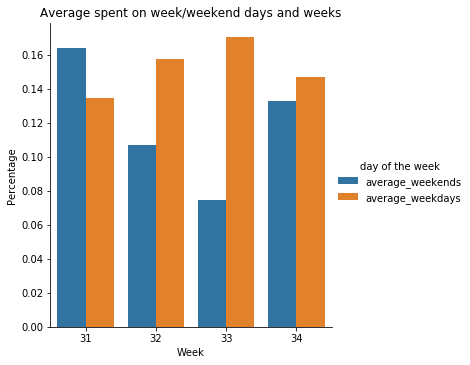

In [1051]:
#Plot graphic
df = pd.melt(average_per_week, id_vars = 'week', var_name = 'day of the week', value_name = 'percentage').sort_values(by=['week'])
sns.factorplot(x='week', y='percentage', hue='day of the week', data=df, kind='bar')
plt.title('Average spent on week/weekend days and weeks')
plt.ylabel('Percentage')
plt.xlabel('Week')


## Questão 4

In [1052]:
#Drop NaN rows to optimze search
online_views1 = online_views.dropna(subset = ['customer_id'])
offline_sales1 = offline_sales.dropna(subset = ['customer_id'])
online_views1.sort_values(by=['customer_id'], inplace = True)

#Search common customers in offline_sales and online_views
looked_online_bought_offline = []
for customer_id in offline_sales1['customer_id']:
    if customer_id in set(online_views1['customer_id']):
        looked_online_bought_offline.append(customer_id)
    
looked_online_bought_off = len(set(looked_online_bought_offline))



/dev/data/home/eller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [1053]:
#Calculates the percentage of customers that looked online and bought offline in relation to all offline sales
percentage_customers_looked_online_bought_offline = looked_online_bought_off/offline_sales['sale_id'].nunique()
print('The percentage of customers that looked online and bought offline in relation to all offline sales is:', round(percentage_customers_looked_online_bought_offline*100,3),'%')

The percentage of customers that looked online and bought offline in relation to all offline sales is: 4.05 %


### Análises adicionais  - Probabilidades

In [1054]:
#Calculate the sample space of the probabilities
sample_space = dados_estados_brasileiros['habitants'].sum()

#Calculate number of elements in events
looked_online = online_views['visitor_id'].nunique()
bought_offline = offline_sales['sale_id'].nunique()
looked_online_bought_off = len(set(looked_online_bought_offline))

#Calculate probabilities of the events
probability_looking_online = looked_online/sample_space
probability_buying_offline = bought_offline/sample_space
probability_not_looking_online_buying_offline = (bought_offline - looked_online_bought_off)/sample_space
probability_looking_online_buying_offline = looked_online_bought_off/looked_online


,probability,values
0,Probability looking online,0.007011
1,Probability buying offline,0.000119
2,"Probability not looking online, buying offline",0.000114
3,"Probability looking online, buying offline",0.000685


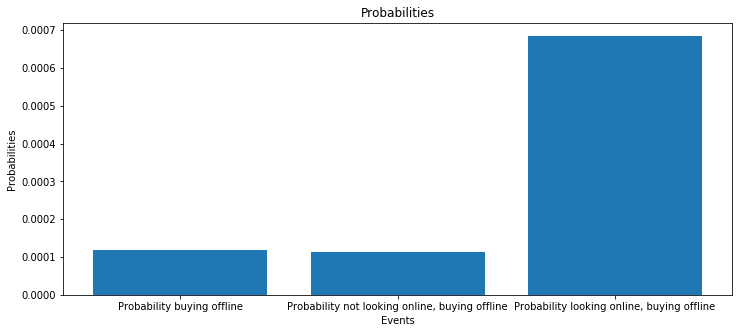

In [1055]:
#Plot graph
probability_data = {'probability' : ['Probability looking online', 'Probability buying offline', 'Probability not looking online, buying offline', 'Probability looking online, buying offline'],
                   'values' : [round(probability_looking_online,6), round(probability_buying_offline,6), round(probability_not_looking_online_buying_offline,6), round(probability_looking_online_buying_offline,6)]}

plt.rcParams['figure.figsize'] = (12,5)
probabilities = pd.DataFrame(probability_data)
plt.bar(probability_data['probability'][1:4], probability_data['values'][1:4])
plt.title('Probabilities')
plt.ylabel('Probabilities')
plt.xlabel('Events')

probabilities


### Fluxo de produtos 

In [1056]:
#Search common customer in page_views and online_orders
looked_online_with_id_bought_online_list = []
for customer_id in online_orders['customer_id']:
    if customer_id in set(online_views1['customer_id']):
        looked_online_with_id_bought_online_list.append(customer_id)


In [1057]:
online_views2 = online_views.dropna(subset = ['customer_id'])

#Node 1 Sankey
looked_online_all = online_views['on_product_id'].count()
online_views2 = online_views.dropna(subset = ['customer_id'])
looked_online_with_id = online_views2['on_product_id'].count()
looked_online_no_id = looked_online_all - looked_online_with_id

#Node 2 Sankey
online_orders2 = online_orders.dropna(subset = ['customer_id'])
looked_online_with_id_bought_online = online_orders2['on_product_id'].count()
looked_online_with_id_didnt_buy_online = looked_online_with_id - looked_online_with_id_bought_online

#Node 3 Sankey
looked_online_no_id_bought_online = len(online_orders['visitor_id']) - looked_online_with_id_bought_online
looked_online_no_id_didnt_buy = looked_online_no_id - looked_online_no_id_bought_online

#Node 4 Sankey
looked_online_with_id_didnt_buy_online_bought_offline = looked_online_bought_off
looked_online_with_id_didnt_buy = looked_online_with_id_didnt_buy_online - looked_online_with_id_didnt_buy_online_bought_offline



In [1058]:
#Plot Sankey Diagram

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["0 Products displayed online (all)", "1 Products displayed online with id","2 Products displayed online without id", 
               "3 Products sold online without id", "4 Products displayed online without id not sold",
               "5 Products sold online with id", "6 Products displayed online with id not sold online",
                "7 Products displayed online with id sold offline", "8 Products displayed online with id not sold"],
      color = "blue"
    ),
    link = dict(
      source = [0, 0, 2, 2, 1, 1, 6, 6], # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = [1, 2, 3, 4, 5, 6, 7, 8],
      value = [looked_online_with_id, looked_online_no_id, looked_online_no_id_bought_online, looked_online_no_id_didnt_buy, looked_online_with_id_bought_online, looked_online_with_id_didnt_buy_online, looked_online_with_id_didnt_buy_online_bought_offline, looked_online_with_id_didnt_buy]
  ))])

fig.update_layout(title_text="Pipeline convertion", font_size=10)
fig.show()



## Questão 5

In [1059]:
#Make the dataframe with customers that abandonned a cart
online_orders1 = online_orders.dropna(subset = ['customer_id'])
online_checkout = online_views1[online_views1['pageType'] == 'checkout']
abandonned_cart = pd.concat([online_orders1, online_checkout]).drop_duplicates(subset = ['customer_id'], keep = False)

#Make the dataframe with customers that abandonned a cart and bought offline
abandonned_cart_bought_offline = pd.merge(abandonned_cart, offline_sales, how = "inner", on = ['customer_id']).drop_duplicates(subset = ['customer_id'], keep = False)

#Make the dataframe with customers that abandonned a cart and didn't buy offline
abandonned_cart_didnt_buy = pd.concat([abandonned_cart, abandonned_cart_bought_offline]).drop_duplicates(subset = ['customer_id'], keep = False).drop(['totalPrice_y'], axis = 1)['customer_id'].count()

#Calculates average spent per sale for each customer who bought offline
average_spent_per_sale = pd.DataFrame(offline_sales.groupby(['customer_id','sale_id'])['totalPrice'].mean().groupby('customer_id').mean()).rename(columns = {0:'customer_id', 1:'average_price'})

#Merge dataframes
abandonned_cart_bought_offline = pd.merge(abandonned_cart_bought_offline, average_spent_per_sale, how = 'inner', on = ['customer_id'])

#Calculate max revenue with the discount
max_revenue = abandonned_cart_bought_offline['totalPrice'].sum()*0.8 + abandonned_cart_didnt_buy*offline_sales['totalPrice'].mean()*0.8

#Revenue expected based on research
expected_revenue = abandonned_cart_bought_offline['totalPrice'].sum()*0.8*0.27 + abandonned_cart_didnt_buy*offline_sales['totalPrice'].mean()*0.8*0.1

#Sensibility analysis
pessimist_revenue = abandonned_cart_bought_offline['totalPrice'].sum()*0.8*0.22 + abandonned_cart_didnt_buy*offline_sales['totalPrice'].mean()*0.8*0.05
optimist_revenue = abandonned_cart_bought_offline['totalPrice'].sum()*0.8*0.32 + abandonned_cart_didnt_buy*offline_sales['totalPrice'].mean()*0.8*0.15

print('Max revenue is:', max_revenue,
      '\n pessimist revenue is:', pessimist_revenue,
      '\n expected revenue is:', expected_revenue, 
      '\n optimist revenue is:', optimist_revenue)

/dev/data/home/eller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


/dev/data/home/eller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




Max revenue is: 399495.9400390625 
 pessimist revenue is: 21583.405001953124 
 expected revenue is: 41558.20200390625 
 optimist revenue is: 61532.999005859376


## Other analysis

### Store's profile

Text(0, 0.5, 'Frequency')

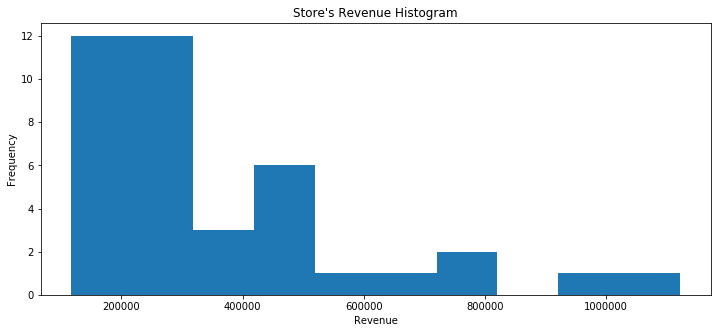

In [1060]:
#Revenue Histogram
plt.hist(offline_sales.groupby('store_id')['totalPrice'].sum())
plt.title("Store's Revenue Histogram")
plt.xlabel('Revenue')
plt.ylabel('Frequency')


Text(0, 0.5, 'Revenue')

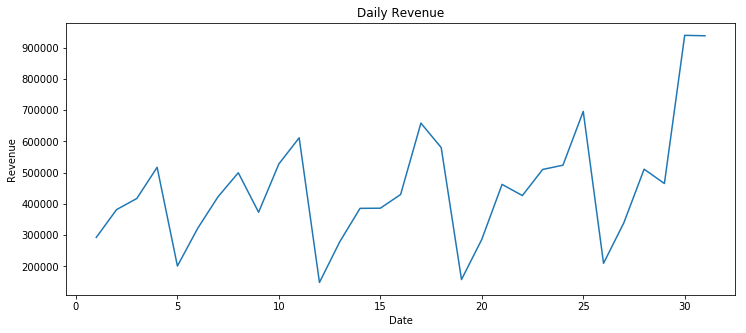

In [1061]:
#Daily Revenue
offline_sales['day'] = offline_sales['date'].dt.day
daily_revenue = offline_sales.groupby('day')['totalPrice'].sum()
plt.plot(daily_revenue)
plt.title('Daily Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')


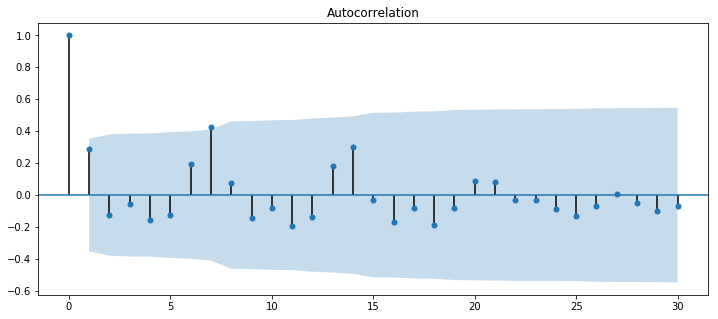

In [1062]:
#Autocorrelation graph
plot_acf(daily_revenue);

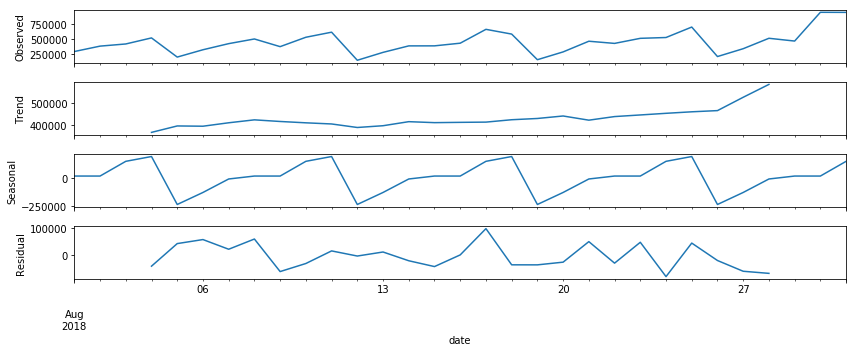

In [1063]:
#Time-series decomposition
daily_revenue = offline_sales.groupby('date')['totalPrice'].sum()
result = seasonal_decompose(daily_revenue, model='aditive')
result.plot();

Text(0.5, 1.0, 'Average Ticket Histogram')

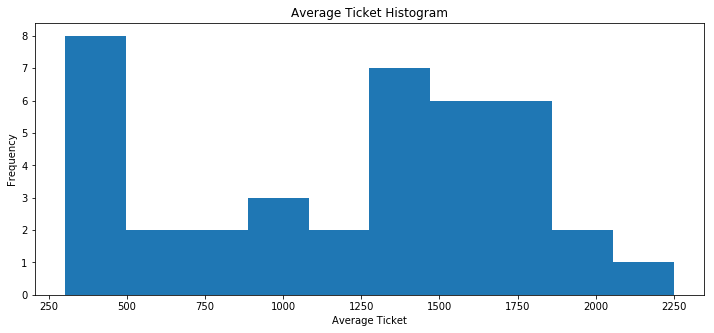

In [1064]:
#Average Ticket Histogram
plt.hist(offline_sales.groupby(['sale_id', 'store_id'], as_index = False)['totalPrice'].sum().groupby('store_id')['totalPrice'].mean())
plt.xlabel('Average Ticket')
plt.ylabel('Frequency')
plt.title('Average Ticket Histogram')


Text(0.5, 1.0, 'Average Number of Items per Purchase per Store Histogram')

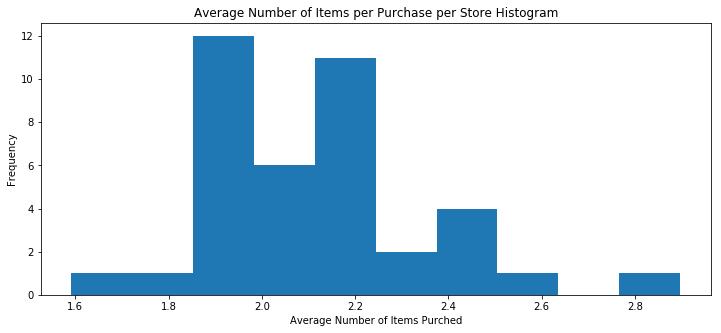

In [1065]:
#Average number of items per sale per store
plt.hist(offline_sales.groupby(['store_id', 'sale_id'], as_index = False)['quantity'].sum().groupby('store_id')['quantity'].mean())
plt.xlabel('Average Number of Items Purched')
plt.ylabel('Frequency')
plt.title('Average Number of Items per Purchase per Store Histogram')


### Geographic aspects

Text(0, 0.5, 'Revenue')

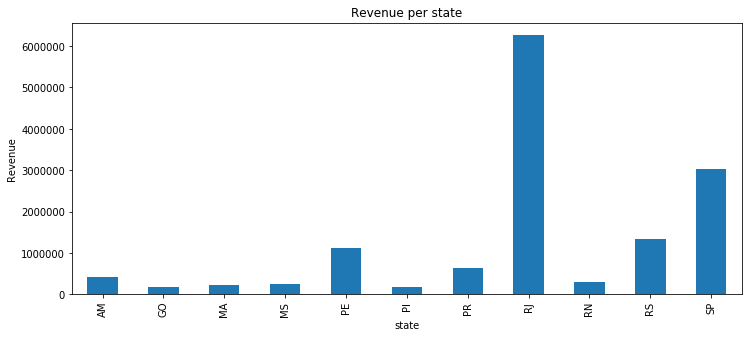

In [1066]:
#Revenue per state
offline_sales.groupby('state')['totalPrice'].sum().plot(kind = 'bar')
plt.title('Revenue per state')
plt.ylabel('Revenue')

Text(0, 0.5, 'Stores')

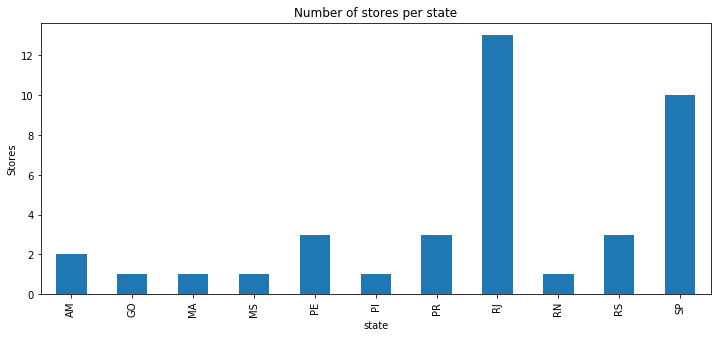

In [1067]:
#Number of stores per state
offline_sales.groupby('state')['store_id'].nunique().plot(kind = 'bar')
plt.title('Number of stores per state')
plt.ylabel('Stores')

Text(0, 0.5, 'Revenue')

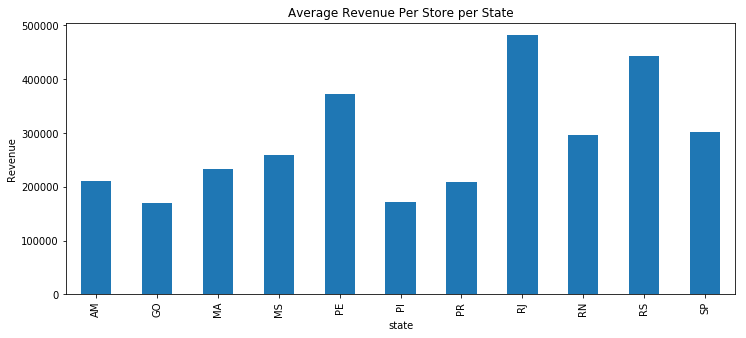

In [1068]:
#Average revenue per store per state
offline_sales.groupby(['state', 'store_id'])['totalPrice'].sum().groupby('state').mean().plot(kind='bar')
plt.title('Average Revenue Per Store per State')
plt.ylabel('Revenue')

### Distribution channels



Text(0, 0.5, 'Revenue')

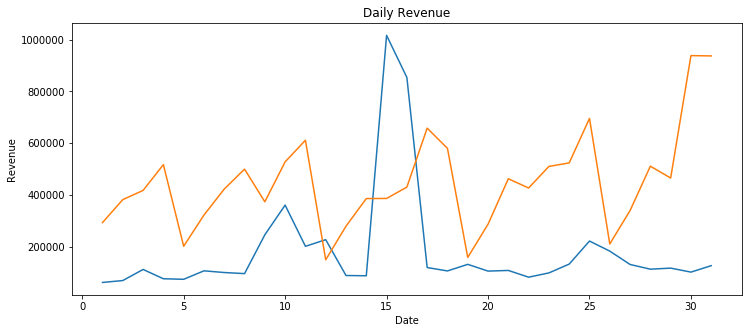

In [1069]:
#Comparison of daily revenue
online_orders['day'] = online_orders['date'].dt.day
daily_revenue = online_orders.groupby('day')['totalPrice'].sum()
plt.plot(daily_revenue)
plt.title('Daily Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')

offline_sales['day'] = offline_sales['date'].dt.day
daily_revenue = offline_sales.groupby('day')['totalPrice'].sum()
plt.plot(daily_revenue)
plt.title('Daily Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')

Text(0.5, 1.0, 'Revenue by Distribution Channel')

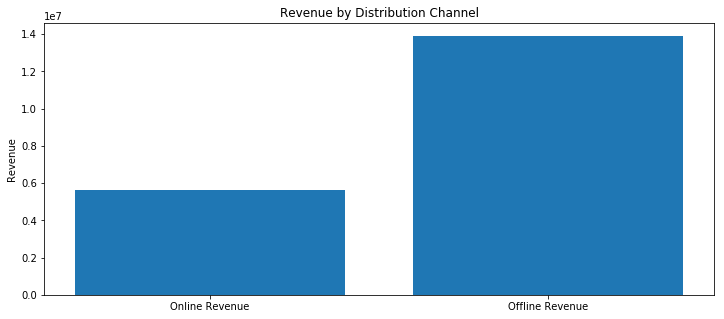

In [1070]:
#Revenue by distribution channel
online_revenue = online_orders['totalPrice'].sum()
offline_revenue = offline_sales['totalPrice'].sum()
plt.bar(['Online Revenue', 'Offline Revenue'], [online_revenue,offline_revenue])
plt.ylabel('Revenue')
plt.title('Revenue by Distribution Channel')

Text(0.5, 1.0, 'Averate Ticket by Distribution Channel')

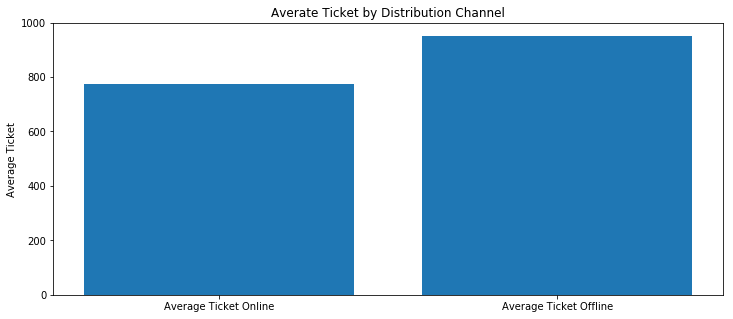

In [1071]:
#Average ticket by distribution channel
average_ticket_off = offline_sales.groupby(['sale_id'], as_index = False)['totalPrice'].sum()['totalPrice'].mean()
average_ticket_on = online_orders.groupby(['order_id'], as_index = False)['totalPrice'].sum()['totalPrice'].mean()
plt.bar([ 'Average Ticket Online','Average Ticket Offline'], [average_ticket_on,average_ticket_off])
plt.ylabel('Average Ticket')
plt.title('Averate Ticket by Distribution Channel')



Text(0.5, 1.0, 'Averate Ticket by Distribution Channel')

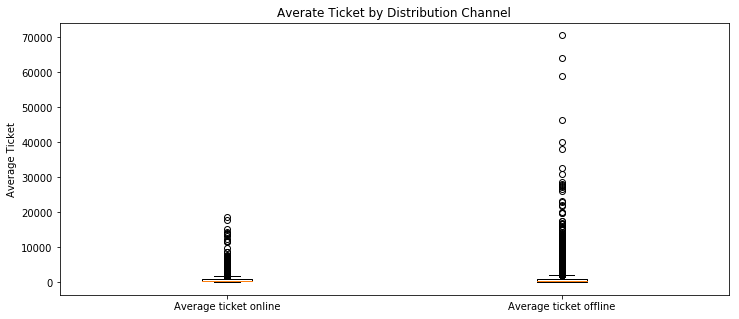

In [1072]:
#Average ticket by distribution channel
average_ticket_off = offline_sales.groupby(['sale_id'], as_index = False)['totalPrice'].sum()['totalPrice']
average_ticket_on = online_orders.groupby(['order_id'], as_index = False)['totalPrice'].sum()['totalPrice']

dict_ticket = {'Average ticket online' : average_ticket_on, 'Average ticket offline' : average_ticket_off}

fig, ax = plt.subplots()
ax.boxplot(dict_ticket.values())
ax.set_xticklabels(dict_ticket.keys())
plt.ylabel('Average Ticket')
plt.title('Averate Ticket by Distribution Channel')


### Online pageviews and online orders

Text(0.5, 1.0, 'Online pageviews by device type')

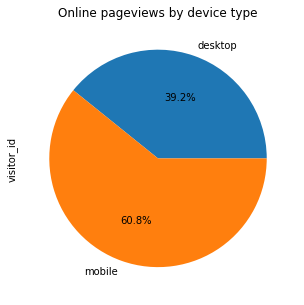

In [1073]:
#Online pageviews by device
online_views.groupby('deviceType')['visitor_id'].count().plot(kind = 'pie', autopct='%1.1f%%')
plt.title('Online pageviews by device type')


Text(0.5, 1.0, 'Online orders by device type')

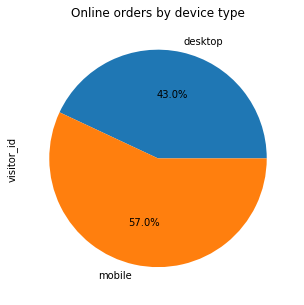

In [1074]:
#Online orders by device
online_orders.groupby('deviceType')['visitor_id'].count().plot(kind = 'pie', autopct='%1.1f%%')
plt.title('Online orders by device type')

In [1075]:
#Recomendation system for online orders
market_basket = online_orders.groupby(['order_id', 'on_product_id'])['quantity'].sum().unstack().reset_index().fillna(0).set_index('order_id')

def encode_data(datapoint):
    if datapoint <= 0:
        return 0
    if datapoint >= 1:
        return 1

market_basket = market_basket.applymap(encode_data)
itemsets = apriori(market_basket, min_support=0.001, use_colnames=True)
rules = association_rules(itemsets, metric="lift", min_threshold=0.5)

In [1076]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(393165333934626),(303261343732316),0.002468,0.001645,0.001097,0.444444,270.111111,0.001093,1.797038
1,(303261343732316),(393165333934626),0.001645,0.002468,0.001097,0.666667,270.111111,0.001093,2.992596
2,(313932393861643),(343364366431383),0.002879,0.001097,0.001097,0.380952,347.285714,0.001094,1.613613
3,(343364366431383),(313932393861643),0.001097,0.002879,0.001097,1.000000,347.285714,0.001094,inf
4,(396464373131666),(656662626334303),0.006445,0.006170,0.001097,0.170213,27.585816,0.001057,1.197692
5,(656662626334303),(396464373131666),0.006170,0.006445,0.001097,0.177778,27.585816,0.001057,1.208378


In [1077]:
print("My program took", time.time() - start_time, "to run")

My program took 910.4115052223206 to run
